In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from keras.models import *
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D, AvgPool2D, Flatten, Dense
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras import preprocessing
from keras.preprocessing import image
import keras
from keras import optimizers
import cv2
import tqdm
import pickle
from tqdm import tqdm
%matplotlib inline
import warnings
from IPython.display import clear_output

warnings.filterwarnings('ignore')

WITH_SENTENCE=True
FIT_RESIDUALS=False
SENTENCE_LENGTH = 1 #16 #9
NUM_DIFF_WORDS = 2


C:\Users\Camilo\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load dataset

In [2]:
f = open('cap2vid/dataset/walking/pickle_x_1.pkl', 'rb')
X1 = pickle.load(f)
f.close()
f = open('cap2vid/dataset/walking/pickle_x_2.pkl', 'rb')
X2 = pickle.load(f)
f.close()
f = open('cap2vid/dataset/walking/pickle_x_3.pkl', 'rb')
X3 = pickle.load(f)
f.close()
f = open('cap2vid/dataset/walking/pickle_x_4.pkl', 'rb')
X4 = pickle.load(f)
f.close()

In [3]:
X = []
X.extend(X1)
X.extend(X2)
X.extend(X3)
X.extend(X4)
print(len(X))

400


In [4]:
# To numpy array and keep only first channel
for i in range(len(X)):
    X[i] = np.array(X[i], dtype=np.float32)[:,:,:,0]
    

In [5]:
#skip some frames
Xnew = []
for i in range(len(X)):
    Xnew.append(X[i][0:X[i].shape[0]:5, :, :])


In [6]:
# Printing shapes before and after taking only 
print(X[0].shape)
print(Xnew[0].shape)

(75, 120, 160)
(15, 120, 160)


In [7]:
X = Xnew

In [8]:
#resize
X2 = []
for i in tqdm(range(len(X))):
    arr = np.zeros(shape=(X[i].shape[0], 128,128), dtype=np.float32)
    for j in range(X[i].shape[0]):
        arr[j] = cv2.resize(X[i][j], (128,128))
    X2.append(arr)

100%|██████████| 400/400 [00:04<00:00, 90.24it/s] 


In [9]:
print(X2[0].dtype)
print(len(X2))

float32
400


In [10]:
del X

In [11]:
imgs = X2

(15, 128, 128)


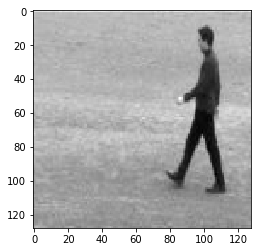

In [12]:
print(X2[0].shape)
plt.imshow(X2[0][4,:,:],cmap='gray')

In [13]:
# Captions
f = open('cap2vid/dataset/walking/pickle_y.pkl', 'rb')
Y = pickle.load(f)
f.close()
Y = np.array(Y, dtype=np.float32)
Y = Y.reshape(-1,1)
print(Y.shape)
captions = Y
print(Y.dtype)

(400, 1)
float32


In [14]:

def encode_caption_in_image(caption, width, height):
    return cv2.resize(caption, (width,height), interpolation=cv2.INTER_NEAREST)

def encode_caption_in_image_onehot(caption, width, height, resize=True):
    res_matrix = np.zeros(shape=(SENTENCE_LENGTH,NUM_DIFF_WORDS))
    for windex in range(len(caption)):
        vec = one_hot(caption[windex])
        res_matrix[windex] = vec
    if resize:
        res_matrix = cv2.resize(res_matrix, (width,height), interpolation=cv2.INTER_NEAREST)
    return res_matrix

def one_hot(val):
    val = int(val)
    vec = np.zeros(NUM_DIFF_WORDS)
    vec[val] = 1
    return vec
   

In [15]:
imgs_captions_small = []
for i in range(captions.shape[0]):
    imgs_captions_small.append(encode_caption_in_image_onehot(captions[i], 64, 64, resize=False).flatten())
    
#imgs_captions = np.array(imgs_captions)
imgs_captions_small = np.array(imgs_captions_small)

In [16]:
print(len(X2))
print(captions.shape)
print(imgs_captions_small.shape)

400
(400, 1)
(400, 2)


In [17]:
num_sequences = 400
length_sequences = 10

In [18]:
num_examples = 120 #80 before, use all

X_img_in = [] 
X_captions_in = []
Y_img_out = []

for i in tqdm(range(num_examples)): #imgs.shape[0])):
    this_sequence = imgs[i] #shape (10,64,64)
    for num_previous_included in range(1, this_sequence.shape[0]):
        #print(num_previous_included)
        X_this = np.zeros(shape=(128,128,length_sequences))
        prev_frames = this_sequence[max(0,num_previous_included-10):num_previous_included] #this_sequence[0:num_previous_included]
        prev_frames = np.swapaxes(prev_frames, 0, 1)
        prev_frames = np.swapaxes(prev_frames, 1, 2)
        X_this[:,:,0:num_previous_included] = prev_frames #X_this[:,:,0:num_previous_included] = prev_frames
        next_frame = this_sequence[num_previous_included]
        
        X_img_in.append(X_this.copy())
        X_captions_in.append(imgs_captions_small[i])
        Y_img_out.append(next_frame.reshape(128,128,1))

X_img_in = np.array(X_img_in, dtype=np.float32)
X_captions_in = np.array(X_captions_in, dtype=np.float32)
Y_img_out = np.array(Y_img_out, dtype=np.float32)
print(X_img_in.shape)
print(X_captions_in.shape)
print(Y_img_out.shape)

100%|██████████| 120/120 [00:03<00:00, 27.54it/s]


(2336, 128, 128, 10)
(2336, 2)
(2336, 128, 128, 1)


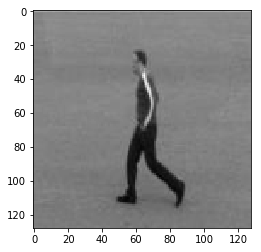

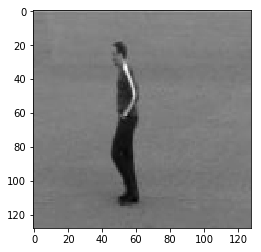

In [19]:
plt.imshow(X_img_in[320,:,:,7], cmap='gray')
plt.figure()
plt.imshow(Y_img_out[320,:,:,0], cmap='gray')

In [20]:
X_img_in/=255.0
Y_img_out/=255.0

print(X_img_in.min(), X_img_in.max())
print(X_captions_in.min(), X_captions_in.max())
print(Y_img_out.min(), Y_img_out.max())

0.0 1.0
0.0 1.0
0.017386641 1.0


## Train and test sets

In [21]:
frac = 0.8
mask = np.random.binomial(1, frac, size=X_img_in.shape[0])
mask = np.array(mask, dtype=np.bool)
X_img_train = X_img_in[mask]
X_captions_train = X_captions_in[mask]
Y_img_train = Y_img_out[mask]

X_img_test = X_img_in[~mask]
X_captions_test = X_captions_in[~mask]
Y_img_test = Y_img_out[~mask]

print('Shape of X_img_train, X_captions_train, Y_img_train, X_img_test, X_captions_test, Y_img_test',
     X_img_train.shape, X_captions_train.shape, Y_img_train.shape, X_img_test.shape, X_captions_test.shape, Y_img_test.shape)

Shape of X_img_train, X_captions_train, Y_img_train, X_img_test, X_captions_test, Y_img_test (1865, 128, 128, 10) (1865, 2) (1865, 128, 128, 1) (471, 128, 128, 10) (471, 2) (471, 128, 128, 1)


## Generator and discriminator builder functions

In [22]:
def get_unet(width, height, lrate=1e-4, start_filters=8, dr_rate=0):
    inputs = Input((height, width, 10))
    #inputs2
  
    conv1 = Conv2D(start_filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(start_filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = AvgPool2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(start_filters*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(start_filters*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = AvgPool2D(pool_size=(2, 2))(conv2)
  
    conv3 = Conv2D(start_filters*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(start_filters*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = AvgPool2D(pool_size=(2, 2))(conv3)
  
    conv4 = Conv2D(start_filters*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(start_filters*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
   

    drop4 = Dropout(dr_rate)(conv4) 
    pool4 = AvgPool2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(start_filters*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(start_filters*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(dr_rate)(conv5)

    
    
    flat = keras.layers.Flatten()(conv4)
    inputs_hidden = Input((NUM_DIFF_WORDS*SENTENCE_LENGTH,), name='hidden_input')#, tensor=conv4), name='input_hidden'
    hiddenmerge = merge([flat,inputs_hidden], mode = 'concat', concat_axis = 1, name='hidden_merge')
    dense1 = keras.layers.Dense(1024, activation='relu', name='dense1')(hiddenmerge)
    dense2 = keras.layers.Dense(8192, activation='relu', name='dense2')(dense1)
    rshp = keras.layers.Reshape(target_shape=(8,8,128))(dense2)
 

    
    #14,14,64
    up6 = Conv2D(start_filters*8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(rshp))
    merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
    conv6 = Conv2D(start_filters*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(start_filters*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    
    
   
    
    up7 = Conv2D(start_filters*4, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))#conv4
    merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
    conv7 = Conv2D(start_filters*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(start_filters*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(start_filters*4, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
    conv8 = Conv2D(start_filters*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(start_filters*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(start_filters, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
    conv9 = Conv2D(start_filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(start_filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)


    
    model = Model(input = [inputs, inputs_hidden], output = conv10)

    return model

In [23]:
def build_discriminator_frames(input_frames_dim):
    
    drop_p = 0.1
    
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=1, input_shape=input_frames_dim, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(AvgPool2D(pool_size=(2, 2)))
    model.add(Dropout(drop_p))
    
    model.add(Conv2D(64, kernel_size=3, strides=1, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(AvgPool2D(pool_size=(2, 2)))
    model.add(Dropout(drop_p))
    
    model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(AvgPool2D(pool_size=(2, 2)))
    model.add(Dropout(drop_p))
    
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dropout(drop_p))
    
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    img = Input(shape=input_frames_dim)
    validity = model(img)

    return Model(img, validity)


In [24]:
print('Shape of X_img_train, X_captions_train, Y_img_train, X_img_test, X_captions_test, Y_img_test',
     X_img_train.shape, X_captions_train.shape, Y_img_train.shape, X_img_test.shape, X_captions_test.shape, Y_img_test.shape)

Shape of X_img_train, X_captions_train, Y_img_train, X_img_test, X_captions_test, Y_img_test (1865, 128, 128, 10) (1865, 2) (1865, 128, 128, 1) (471, 128, 128, 10) (471, 2) (471, 128, 128, 1)


## Constants for training

In [33]:
lr_gen = 0.00001
lr_disc = 0.00002
lr_combined = 0.00001

batchsize_pretrain = 16
batchsize = 8

train_epochs = 5

d_upd = 5
g_upd = 1

## Building the computational graph of the GAN

In [34]:
from keras.layers import LeakyReLU, ZeroPadding2D, BatchNormalization

# Build and compile discrim
discrim = build_discriminator_frames(Y_img_out[0].shape)
discrim.compile(loss='binary_crossentropy', optimizer= Adam(lr_disc), metrics=['accuracy']) #Removed 0.5 from adam
discrim.summary()

load_gen=True
if load_gen:
    # load existing model
    model = keras.models.load_model('gan_walking_ckpts/weights.50.hdf5')
else:
    # Build generator
    model = get_unet(128, 128, lrate=0.0001, start_filters=8, dr_rate=0.5) #best so far: 0.001

# Generator takes img and caption as input
captions_input_node = Input((NUM_DIFF_WORDS*SENTENCE_LENGTH,), name='hidden_input')#, tensor=conv4), name='input_hidden'
img_input_node = Input((128, 128, 10))

frame = model([img_input_node, captions_input_node])

# For the combined model we will only train the generator
discrim.trainable = False

# The discriminator takes generated frames as input and determines validity
valid = discrim(frame)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 455297    
Total params: 455,297
Trainable params: 454,337
Non-trainable params: 960
_________________________________________________________________


## Training the GAN

In [35]:
def generate_and_save(img_input, sentence_input, img_groundtruth, generator, folder, show=True, N=1, name=''):
    
    idx = np.random.randint(0, img_input.shape[0], size=N)

    for i in idx:
        plt.figure(figsize=[10,10])
        current_sent = sentence_input[i].reshape(1,NUM_DIFF_WORDS*SENTENCE_LENGTH)
        current_im = img_input[i].reshape(1,128,128,10).copy()
        img_pred = generator.predict(x=[current_im, current_sent])
        for f in range(10):
            ax = plt.subplot2grid((4, 5), (f//5, f%5))
            ax.imshow(img_input[i][:,:,f], cmap='gray')
            ax.set_axis_off()
        
        ax1 = plt.subplot2grid((4, 5), (2,0), colspan=2, rowspan=2)
        ax1.imshow(img_pred[0,:,:,0], cmap='gray')
        ax1.set_axis_off()
        ax1.set_title('Predicted')
        ax2 = plt.subplot2grid((4, 5), (2,3), colspan=2, rowspan=2)
        ax2.imshow(img_groundtruth[i][:,:,0], cmap='gray') 
        ax2.set_axis_off()
        ax2.set_title('Ground truth')
        if current_sent[0][0] ==1:
            caption = '"a person walking to the left"' 
        else:
            caption = '"a person walking to the right"' 
        plt.suptitle('Caption: '+caption+'\n\nInput images' , y=0.93)
        plt.subplots_adjust(wspace=0.05, hspace=0.0001)
        plt.savefig(os.path.join(folder, 'gen_result_'+name+'_'+str(i)+'.png'), bbox_inches='tight')
        plt.show()

#### Pretrain Discriminator 

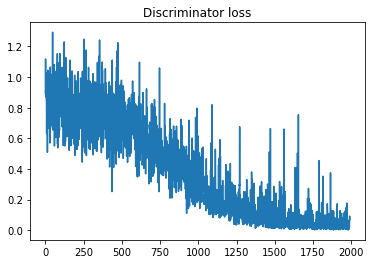

100%|██████████| 2000/2000 [03:20<00:00,  9.99it/s]


In [36]:
# PRETRAIN DISCR

def train_discrim(d_it = 1500, plot_progress=True, plot = False):
    #If generator has been loaded, pretrain the discriminator for d_it iterations
    
    losses = []
    if plot_progress:
        plt.figure()
        
    for d in tqdm(range(d_it), disable=(not plot_progress)):
        # Select a random half batch of real frames
        index = np.random.randint(0, Y_img_train.shape[0], int(batchsize_pretrain / 2.))
        frames = Y_img_train[index]
                    
        # Generate a random half batch of generator frames
        index = np.random.randint(0, X_img_train.shape[0], size=int(batchsize_pretrain / 2.))
        gen_frames = model.predict(x=[X_img_train[index], X_captions_train[index]])

        # Fit discrim on real frames
        d_loss_real = discrim.train_on_batch(x = frames, y=np.ones((int(batchsize_pretrain/ 2.), 1))) 
        
        # Fit discrim on generated frames
        d_loss_fake = discrim.train_on_batch(x = gen_frames, y=np.zeros((int(batchsize_pretrain / 2.), 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        losses.append(d_loss)
        
        if plot_progress:
            if not d%10:
                clear_output(wait=True)
                plt.plot([l[0] for l in losses])
                plt.title('Discriminator loss')
                plt.show()
                if plot:
                    plt.show()
                    plt.figure()
                    plt.imshow(frames[0,:,:,0], cmap='gray')
                    plt.show()
                    plt.figure()
                    plt.imshow(gen_frames[0,:,:,0],cmap='gray')
                    plt.show()
    return losses

    
load_discrim = False                   
if load_gen:
    if load_discrim:
        print('Loading Discriminator...')
        discrim = keras.models.load_model('./gan_walking_ckpts/discrim_it4500.hdf5')
        print('Done.')
    else:
        d_it=2000
        train_discrim(d_it = d_it)
        save_model(discrim, './gan_walking_ckpts/discrim_it'+str(d_it)+'.hdf5')


### Train GAN - simple training

Classic GAN training with cross entropy loss.

In [ ]:
def train_gan_simple(save_m=False):
    for e in range(train_epochs):
        for it in tqdm(range(Y_img_train.shape[0])):
            
            # Train Discriminator
            losses = train_discrim(d_upd, plot_progress=False)
            d_loss = np.mean(losses, axis=0)

            # Fit combined model (generator)
            g_loss = 0
            for i in range(g_upd): # g_upd gen updates per discrim update
                
                # Get batch for combined model
                index = np.random.randint(0, X_img_train.shape[0], size=int(batchsize))
                g_loss += combined.train_on_batch(x=[X_img_train[index], X_captions_train[index]], y=np.ones((batchsize, 1)))
            g_loss /= g_upd
            
            if not it%10:
                if save_m:
                    save_model(model, './gan_walking_ckpts/generator_weights_epoch'+str(e)+'it'+str(it)+'.hdf5')
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f b_c: %f, mse: %f]" % (it, d_loss[0], 100*d_loss[1], g_loss))
                generate_and_save(X_img_test, X_captions_test, Y_img_test, model, 'gan_walking_results', show=True, name='e'+str(e)+'it'+str(it))

            
            
# Compile the combined model (stacked generator and discriminator)
combined = Model([img_input_node, captions_input_node], valid)
combined.compile(loss='binary_crossentropy', optimizer= Adam(lr=lr_combined))
train_gan_simple()

### Train GAN double loss

Train a gan that optimizes 2 losses at the same time: crossentropy through the discriminator, and mse just for the generator.

In [ ]:
def train_gan_double_loss(save_m=False):
    
    for e in range(train_epochs):
        for it in tqdm(range(Y_img_train.shape[0])):
            
            # Train Discriminator
            losses = train_discrim(d_upd, plot_progress=False)
            d_loss = np.mean(losses, axis=0)

            # Fit combined model (generator)
            g_loss_tot = [0,0,0]
            for i in range(g_upd): # g_upd gen updates per discrim update
                # Get batch for combined model
                index = np.random.randint(0, X_img_train.shape[0], size=int(batchsize))
                g_loss = combined.train_on_batch(x=[X_img_train[index], X_captions_train[index]], y=[np.ones((batchsize, 1)),Y_img_train[index]])
                
                g_loss_tot[0] += g_loss[0]
                g_loss_tot[1] += g_loss[1]
                g_loss_tot[2] += g_loss[2]
            
            g_loss_tot = np.array(g_loss_tot)/g_upd

            if not it%10:
                if save_m:
                    save_model(model, './gan_walking_ckpts/generator_weights_epoch'+str(e)+'it'+str(it)+'.hdf5')
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f b_c: %f, mse: %f]" % (it, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1], g_loss[2]))
                generate_and_save(X_img_test, X_captions_test, Y_img_test, model, 'gan_walking_results', show=True, name='e'+str(e)+'it'+str(it))

            
            
# The combined model (stacked generator and discriminator)
combined = Model([img_input_node, captions_input_node], [valid, frame])
combined.compile(loss=['binary_crossentropy','mse'], optimizer= Adam(lr=lr_combined))
train_gan_double_loss()

### Train GAN alternating

Train the GAN for 100 iterations with the discrim, then disconnect discrim and train just the generator with MSE loss for 100 iterations. Repeat.

In [ ]:
def train_gan_alternating(discrim, combined, generator, switch_it = 100, save_m=False):
    print('Starting training')
    train_gan = True

    for e in range(train_epochs):
        for it in tqdm(range(Y_img_train.shape[0])):
            if train_gan:

                # Train Discriminator
                losses = train_discrim(d_upd, plot_progress=False)
                d_loss = np.mean(losses, axis=0)

                # Fit combined model (generator)
                g_loss = 0
                for i in range(g_upd): # g_upd gen updates per discrim update
                    # Get batch for combined model
                    index = np.random.randint(0, X_img_train.shape[0], size=int(batchsize))                
                    g_loss += combined.train_on_batch(x=[X_img_train[index], X_captions_train[index]], y=np.ones((batchsize, 1)))
            
            else:
                g_loss = 0
                for i in range(g_upd): # g_upd gen updates per discrim update
                    # Get batch for combined model
                    index = np.random.randint(0, X_img_train.shape[0], size=int(batchsize))                
                    g_loss += generator.train_on_batch(x=[X_img_train[index], X_captions_train[index]], y=Y_img_train[index])
            
            g_loss = g_loss/g_upd

            if not it%switch_it: 
                print('Switching training loss')
                train_gan = not train_gan

            if not it%10:
                if save_m:
                    save_model(model, './gan_walking_ckpts/generator_epoch'+str(e)+'it'+str(it)+'.hdf5')
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f ]" % 
                       (it, d_loss[0], 100*d_loss[1], g_loss))
                generate_and_save(X_img_train, X_captions_train, Y_img_train, generator, 
                                  'gan_walking_results', show=True, name='e'+str(e)+'it'+str(it))            
            

# Compiling generator
model.compile(optimizer = Adam(lr = 0.0001), loss = 'mse')

# Compiling combined model
combined = Model([img_input_node, captions_input_node], valid)
combined.compile(loss='binary_crossentropy', optimizer= Adam(lr=lr_combined))
train_gan_alternating(discrim, combined, model, switch_it=100)

In [ ]:
# Save model if necessary
save_model(model, './gan_walking_ckpts/generator_f.hdf5')

In [37]:
# Get accuracy of discriminator on training
preds = discrim.predict(Y_img_train)
print(preds.shape)
print(np.mean(preds))

preds_from_gen = discrim.predict(model.predict(x=[X_img_train, X_captions_train]))
print(preds_from_gen.shape)
print(1-np.mean(preds_from_gen))

(1865, 1)
0.5050683
(1865, 1)
0.5045646


In [ ]:
def get_feature_maps(model, layer_in, layer_out, input_image):
    model_ = Model(inputs=[model.layers[layer_in].input], outputs=[model.layers[layer_out].output])
    return model_.predict(input_image)

In [ ]:
# Predict function

def predict(model, img_input, sentence_input, img_groundtruth, recursion=1, flip=False, plot=True):
    print('caption: ', sentence_input)
    
    if flip:
        sentence_input = np.flip(sentence_input, 0)
    if plot:
        print('new caption: ', sentence_input)
        plt.figure()
        plt.title('input frame (previous)')
        plt.imshow(img_input, cmap='gray')
    
    sentence_input = sentence_input.reshape(1,NUM_DIFF_WORDS*SENTENCE_LENGTH)
    current_img_input = img_input.reshape(1,128,128,1).copy()
    
    X_this = np.zeros(shape=(1,128,128,length_sequences))
    insertion = 0
    if plot:
        plt.figure(figsize=(15,15))
    for i in range(recursion):
#         print(current_img_input.shape)
        insertion=i
        if i>=length_sequences:
            print('triggered')
            #insertion = 0#length_sequences-1
            #X_this = np.zeros_like(X_this)
            X_this = np.roll(X_this, -1, axis=3)
            
        X_this[0,:,:,insertion] = current_img_input.reshape(128,128)
        current_img_input = model.predict(x=[X_this, sentence_input])

        if plot:
            plt.subplot(4,5,i+1)
            plt.title('prediction ' + str(i+1))
            plt.imshow(current_img_input[0,:,:,0], cmap='gray')
       
    
    if not img_groundtruth is None and plot:
        plt.figure()
        plt.title('groundtruth')
        plt.imshow(img_groundtruth[:,:,0], cmap='gray')
        
#     return current_img_input

# Compare with best non-gan model

In [ ]:
model_nongan_best = keras.models.load_model('gan_walking_ckpts/weights.450.hdf5')

In [ ]:
index=21
predict(model_nongan_best, X_img_test[index,:,:,0], X_captions_test[index], Y_img_test[index], recursion=10)
predict(model, X_img_test[index,:,:,0], X_captions_test[index], Y_img_test[index], recursion=10)

In [ ]:
index=1050 #1050
predict(model, X_img_test[index,:,:,3], X_captions_test[index], Y_img_out[index], recursion=10, flip=False)

In [ ]:
go_left=True

cap = np.zeros(shape=2, dtype=float)
if go_left:
    cap[0] = 1.0
else:
    cap[1] = 1.0
print(cap)
cam = cv2.imread('IMG_3199.jpg', 0)/255.


predict(model, cam, cap, None, recursion=10, flip=False)

